In [25]:
import numpy as np  
from matplotlib import pyplot as plt 
from PIL import Image    
import torch

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.models.components import feature_extractors
import torchvision
from anomalib.models.components.feature_extractors import TorchFXFeatureExtractor
import torch.nn.functional as F
from anomalib.models.components.cluster.kmeans import KMeans
import torchvision.models as models


In [38]:
MODEL = "patchcore"
CONFIG_PATH = f"/home/students/tyang/anomalib/src/anomalib/models/{MODEL}/config_select.yaml"
with open(file=CONFIG_PATH, mode="r",encoding="utf-8") as f:
    print(f.read())
    
config = get_configurable_parameters(config_path=CONFIG_PATH)

dataset:
  name: airogs
  format: airogs
  path: /home/students/tyang/airogs 
  task: classification # options: [classification, segmentation]
  category: 0
  pre_selection: True
  number_of_samples: 869
  train_batch_size: 32
  eval_batch_size: 32
  num_workers: 8
  image_size: 1250 # dimensions to which images are resized (mandatory)
  center_crop: 700 # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.5 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.5 # fraction of train/test images held out for validation (usage depends on val_split_mode)

  tiling:
    apply: false
    tile_size: null
    stride:

/home/students/tyang/anomalib/src/anomalib/config/config.py:243: UserWarning: The seed value is now fixed to 0. Up to v0.3.7, the seed was not fixed when the seed value was set to 0. If you want to use the random seed, please select `None` for the seed value (`null` in the YAML file) or remove the `seed` key from the YAML file.
  warn(
/home/students/tyang/anomalib/src/anomalib/config/config.py:280: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


In [39]:
data_module = get_datamodule(config=config)
data_module.prepare_data() # check if the dataset is avaliable
data_module.setup()

i, train_data = next(enumerate(data_module.train_dataloader()))

In [40]:
print(train_data["image"].shape)
print(train_data["image"][0].shape)

torch.Size([32, 3, 700, 700])
torch.Size([3, 700, 700])


In [41]:

gray = torchvision.transforms.Grayscale(num_output_channels=1)(train_data["image"])


torch.Size([1, 700, 700])


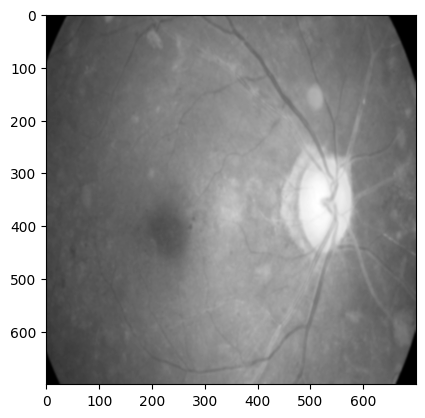

In [42]:
from anomalib.models.components.filters import GaussianBlur2d
print(gray[0].shape)
gaussian_blur = GaussianBlur2d(kernel_size=21, sigma=1.5)
gaussian_blur(gray)
plt.imshow(gaussian_blur(gray)[8].squeeze(), cmap="gray")


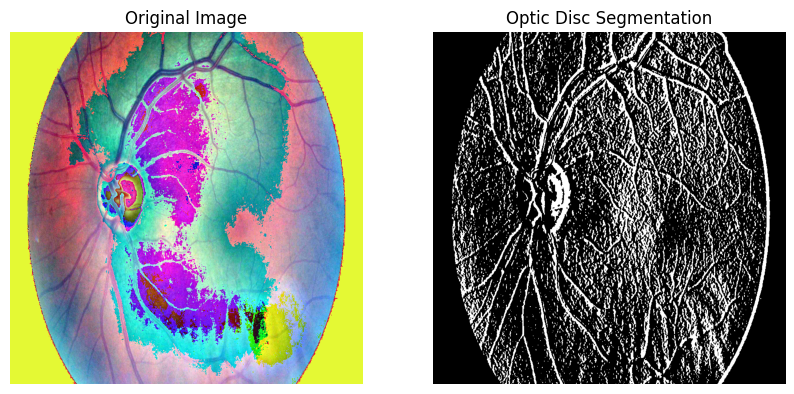

In [19]:
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt



# Convert the tensor image to grayscale
gray_image = gray[8]

# Apply Gaussian blur to the image to reduce noise (you can use a PyTorch filter)
blur = transforms.GaussianBlur(kernel_size=5, sigma=1)
blurred_image = blur(gray_image)

# Perform edge detection using a Sobel filter (you can use a PyTorch filter)
sobel_filter = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32)
edges = torch.nn.functional.conv2d(blurred_image, sobel_filter.unsqueeze(0).unsqueeze(0))

# Thresholding to create a binary mask
threshold = 0.05
optic_disc_mask = edges > threshold

# Visualize the results
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(TF.to_pil_image(train_data["image"][8].squeeze()))
plt.axis('off')

# Display the segmented optic disc
plt.subplot(1, 2, 2)
plt.title('Optic Disc Segmentation')
plt.imshow(optic_disc_mask.squeeze().numpy(), cmap='gray')
plt.axis('off')

plt.show()


In [33]:
import cv2
import numpy as np
from skimage import measure, color

#time cost unaffordable

# Read the retinal image
image_np = (train_data["image"][8].permute(1,2,0).numpy() * 255).astype(np.uint8)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to the image to reduce noise
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Perform edge detection using the Canny edge detector
edges = cv2.Canny(blurred_image, 30, 100)

# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on size and circularity
filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > 100 and 0.05 < cv2.arcLength(contour, True) < 0.2]

# Create a binary mask for the optic disc region
optic_disc_mask = np.zeros_like(gray_image)
cv2.drawContours(optic_disc_mask, filtered_contours, -1, (255), thickness=cv2.FILLED)

# Optionally, apply morphological operations for further cleaning
optic_disc_mask = cv2.morphologyEx(optic_disc_mask, cv2.MORPH_CLOSE, np.ones((10, 10), np.uint8))

# Visualize the results
result_image = cv2.bitwise_and(image_np, image_np, mask=optic_disc_mask)

# Display the original image and the segmented optic disc
cv2.imshow('Original Image', image_np)
cv2.imshow('Optic Disc Segmentation', result_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [43]:
import torch
import torch.nn.functional as F
from torchvision import transforms

# Assuming you have a tensor with shape (1000, 3, 892, 892)
image_tensor = transforms.Grayscale(num_output_channels=1)(train_data["image"])


# Apply GaussianBlur to reduce noise

blurred = transforms.functional.gaussian_blur(image_tensor, kernel_size=9, sigma=1.5)

# Use adaptive thresholding to create a binary mask
thresholded = torch.where(blurred > blurred.mean(), torch.tensor(1.0), torch.tensor(0.0))

# Find contours using Sobel operator
sobel_x = F.conv2d(thresholded, torch.FloatTensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).view(1, 1, 3, 3), padding=1)
sobel_y = F.conv2d(thresholded, torch.FloatTensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]).view(1, 1, 3, 3), padding=1)
gradient_magnitude = torch.sqrt(sobel_x**2 + sobel_y**2)

# Use non-maximum suppression to get thin edges
non_max_suppressed = gradient_magnitude * (gradient_magnitude == F.max_pool2d(gradient_magnitude, kernel_size=3, stride=1, padding=1))

# Apply a threshold to get a binary edge map
edge_map = torch.where(non_max_suppressed > non_max_suppressed.mean(), torch.tensor(1.0), torch.tensor(0.0))
print(edge_map.shape)
result_tensor = image_tensor * (1 - edge_map)
print(result_tensor.shape)




torch.Size([32, 1, 700, 700])
torch.Size([32, 1, 700, 700])


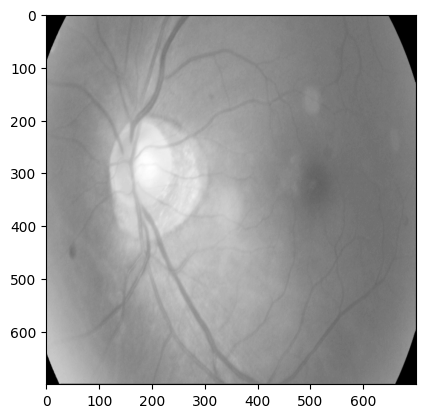

In [44]:
plt.imshow(result_tensor[3].squeeze(), cmap="gray")

In [45]:
image_t_flatten = torch.flatten(result_tensor, start_dim=1)
max_values, max_indices = torch.max(image_t_flatten, dim=1)

In [34]:
image_t_flatten = torch.flatten(gaussian_blur(gray), start_dim=1)
max_values, max_indices = torch.max(image_t_flatten, dim=1)
print(max_values.shape)
print(max_indices.shape)

torch.Size([32])
torch.Size([32])


In [46]:
batch_size, channels, height, width = train_data["image"].shape
max_coordinates = torch.stack([max_indices % width , max_indices // height ], dim=1)
cropped_images = []
crop_size = 240
for i in range(batch_size):
          start_y = max(0, int(max_coordinates[i, 1]) - crop_size // 2)
          end_y = min(int(max_coordinates[i, 1]) + crop_size // 2, height)
          start_x = max(0, int(max_coordinates[i, 0]) - crop_size // 2)
          end_x = min(int(max_coordinates[i, 0]) + crop_size // 2, width)
    
          cropped_image = train_data["image"][i, : ,start_y:end_y ,start_x:end_x,]
          cropped_images.append(cropped_image)

filtered_tensors = [tensor for tensor in cropped_images if tensor.shape[1] > crop_size -90 and tensor.shape[2] > crop_size - 90]
max_height = max(t.shape[1] for t in cropped_images)
max_width = max(t.shape[2] for t in cropped_images)
padded_tensors = [F.pad(t, (0, max_width - t.shape[2], 0, max_height - t.shape[1])) for t in filtered_tensors]
stacked_tensor = torch.stack(padded_tensors)


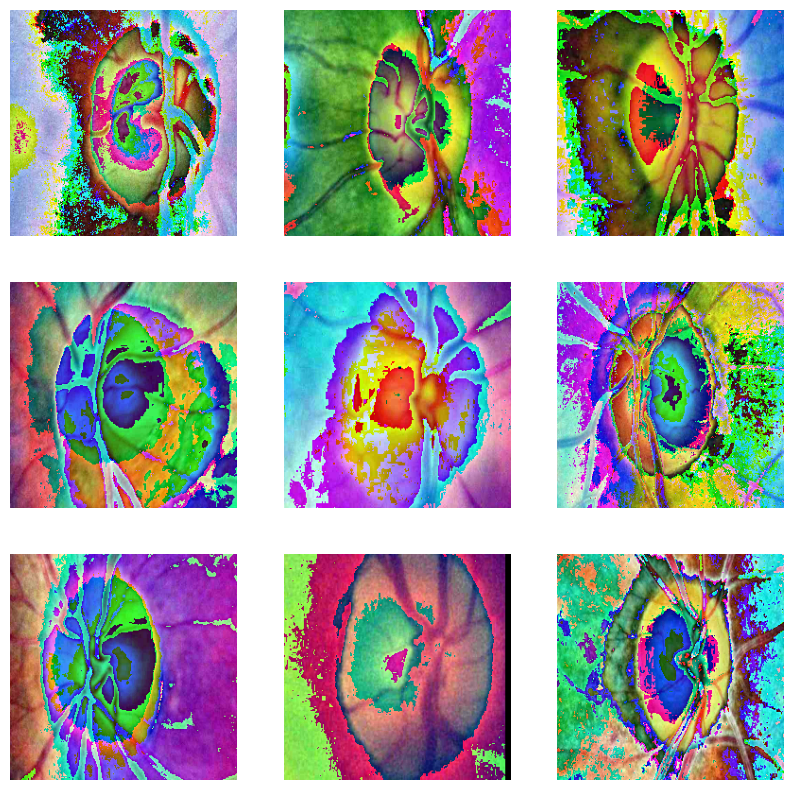

In [51]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(TF.to_pil_image(stacked_tensor[i].squeeze()))
    plt.axis('off')

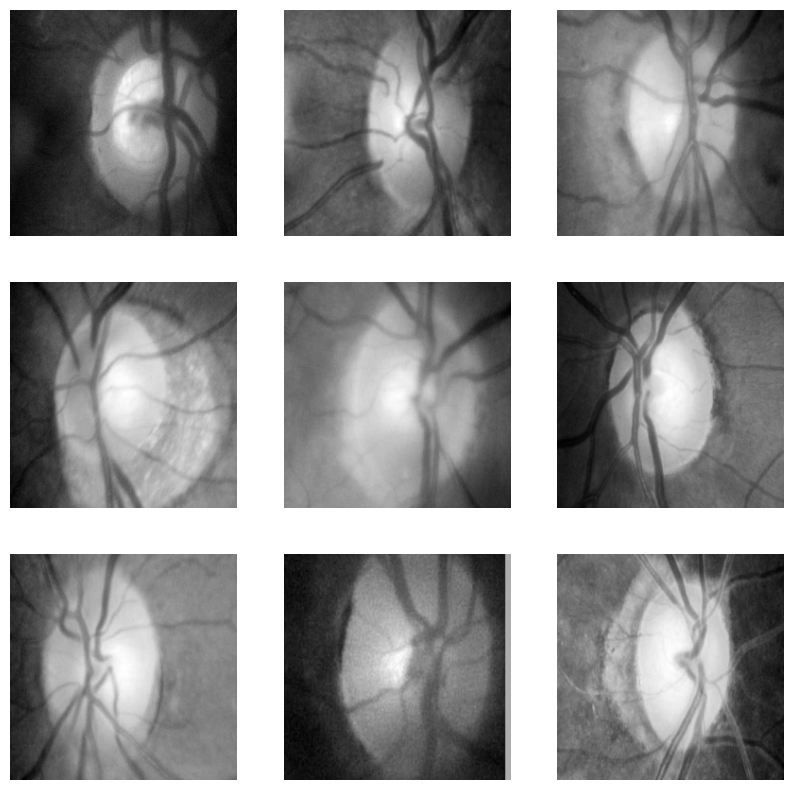

In [54]:
gray_tensor = transforms.Grayscale(num_output_channels=1)(stacked_tensor)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(gray_tensor[i].squeeze(), cmap='gray')
    plt.axis('off')

In [14]:
batch_size, channels, height, width = train_data["image"].shape
max_coordinates = torch.stack([max_indices % width , max_indices // height ], dim=1)
cropped_images = []
crop_size = 240
for i in range(batch_size):
          start_y = max(0, int(max_coordinates[i, 1]) - crop_size // 2)
          end_y = min(int(max_coordinates[i, 1]) + crop_size // 2, height)
          start_x = max(0, int(max_coordinates[i, 0]) - crop_size // 2)
          end_x = min(int(max_coordinates[i, 0]) + crop_size // 2, width)
    
          cropped_image = train_data["image"][i, : ,start_y:end_y ,start_x:end_x,]
          cropped_images.append(cropped_image)
        

max_height = max(t.shape[1] for t in cropped_images)
max_width = max(t.shape[2] for t in cropped_images)
padded_tensors = [F.pad(t, (0, max_width - t.shape[2], 0, max_height - t.shape[1])) for t in cropped_images]
cropped_images_t = torch.stack(padded_tensors)


In [15]:
gray_cropped = torchvision.transforms.Grayscale(num_output_channels=1)(cropped_images_t)
plt.imshow(gray_cropped[3].squeeze(), cmap="gray")

NameError: name 'cropped_images_t' is not defined